In [1]:
import openai
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from googlesearch import search
from docx import Document

import re
import requests
import nltk
import spacy

In [2]:
%cd ..

with open('private.txt', 'r') as f:
    content = f.read()
    key = re.findall(r'\'.*?\'', content)[0].strip('\'')
    openai.api_key = key
f.close()

%cd experiment    

h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp
h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp\experiment


# Utility

In [3]:
def parse_date_from_html(html_string):
    "parse date from html. Input html as byte object. The output is a string."
    try:
        regex = b"\d{4}-\d{2}-\d{2}" # b stands for byte like! not a string yet
        date = re.search(regex, html_string)[0]
        date_string = date.decode('utf-8') # turn to string
    except:
        try:
            regex = b"\d{4}\/\d{2}\/\d{2}" # b stands for byte like! not a string yet
            date = re.search(regex, html_string)[0]
            date_string = date.decode('utf-8')#.replace("/", "-") # turn to string
        except:
            date_string = 'no date detected'
    return date_string

def parse_title_from_html(html_string):
    "parse_title_from_html. Input html as byte object. The output is a string."
    try:
        title = re.search(b'<title>(.*?)</title>', html_string).group(1)
        title = title.decode('utf-8')
        title = title.split('.')[0].split('&')[0].split('|')[0].split('-')[0]
    except:
        title = 'no title detected'
    return title

def google_query(keywords, num_results=10):
  "query google by topics and return the url, the title and the publication date for each search result as lists"
  source_google = []
  titles_google = []
  publication_dates_google = []

  for kw in keywords:
    query = kw
    for url in search(query, num_results, lang="de"):
        # get html string
        html_string = requests.get(url).content     
        # get title
        title = parse_title_from_html(html_string)
        # get date
        date = parse_date_from_html(html_string)
        # save results in lists
        source_google.append(url)
        titles_google.append(title)
        publication_dates_google.append(date)

        print(url)  
        print(title)
        print(date)

  return source_google, titles_google, publication_dates_google

def chatgpt_generate_topics(keywords, num_topics):
    "Give ChatGPT instructions to generate num_topics for the given keywors"
    instruction = \
    '\n' \
    "Nenne zu folgenden Keywords " + '\n' \
    'keywords = ' + str(keywords)  + '\n' \
    ' ' + str(num_topics) + '\n' \
    ' Themenüberschriften.'
    print('Instruction: ', instruction)
    return instruction

# Define Keywords

In [4]:
# define key words
keywords = ['Finanzielle Hilfe im Alter', 
            'Rentner in Not',
            'Armut Senioren',
            'Altersarmut Frauen',
            'Renten Pay-Gap',
            'Unterstützung Rentner']

# Generate Topic List 

## Generate Topics from Latest Article Headlines Found by Google Search

In [5]:
# get google search results for each topic
source_google, titles_google, publication_dates_google = google_query(keywords, num_results=10)

https://familienportal.de/familienportal/lebenslagen/alter/staatliche-leistungen
Staatliche Leistungen im Alter 
no date detected
https://www.caritas.de/hilfeundberatung/ratgeber/alter/pflege/finanzielle-hilfe-wenn-die-rente-nicht-reicht
Finanzielle Hilfe wenn die Rente nicht reicht
2021-10-04
https://www.kennstdueinen.de/magazin/geldnot-im-alter-welche-finanziellen-hilfen-gibt-es-wenn-die-rente-nicht-reicht/
Geldnot im Alter 
2015-09-04
https://www.seniorenlebenshilfe.de/dienstleistungen-fuer-senioren/grundsicherung-im-alter/
Wichtige Infos zur Grundsicherung im Alter 
2021-07-13
https://www.focus.de/finanzen/altersvorsorge/staatliche-unterstuetzung-viel-mehr-geld-im-alter-sieben-lohnende-zuschuesse-fuer-rentner_id_8970984.html
Viel mehr Geld im Alter: Sechs lohnende Zuschüsse für Rentner 
2018-05-25
https://www.einherzfuerrentner.de/fuer-rentner/
Für Rentner 
2023-02-27
https://www.serviceportal-zuhause-im-alter.de/wohnen/laenger-zuhause-wohnen/finanzielle-foerderung.html
Finanzielle

In [6]:
#source_google = []
#titles_google = []
#publication_dates_google = []
len(publication_dates_google)

62

In [7]:
# turn titles and sources into dataframe
df_titles_google = pd.DataFrame({'source': source_google, 'title': titles_google, 'date': publication_dates_google})
df_titles_google.head(10)

,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
5,https://www.einherzfuerrentner.de/fuer-rentner/,Für Rentner,2023-02-27
6,https://www.serviceportal-zuhause-im-alter.de/...,Finanzielle Förderung,no date detected
7,https://www.ihre-vorsorge.de/magazin/lesen/wen...,Wenn das Geld im Alter nicht reicht: Finanziel...,2023-03-06
8,https://www.betanet.de/sozialhilfe-altenhilfe....,Sozialhilfe > Altenhilfe,no date detected
9,https://seniorenhilfe-lichtblick.de/,LichtBlick Seniorenhilfe e,2023-03-06


## Generate Topics Based on ChatGPT

In [8]:
keywords

['Finanzielle Hilfe im Alter',
 'Rentner in Not',
 'Armut Senioren',
 'Altersarmut Frauen',
 'Renten Pay-Gap',
 'Unterstützung Rentner']

In [9]:
instruction = chatgpt_generate_topics(keywords=keywords, num_topics=15)

Instruction:  
Nenne zu folgenden Keywords 
keywords = ['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
 15
 Themenüberschriften.


In [10]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

titles_chatgpt = response['choices'][0].text

# format titles and put into list
titles_chatgpt = [title.strip().replace("\n", "").replace(". ", "") for title in re.split(r'\d+', titles_chatgpt)]

In [11]:
# turn titles and sources into dataframe
date_today = datetime.date.today().strftime("%Y-%m-%d")
df_titles_chatgpt = pd.DataFrame({'source': 'chatgpt', 'title': titles_chatgpt, 'date': date_today})
df_titles_chatgpt.head(10)

,source,title,date
0,chatgpt,,2023-03-07
1,chatgpt,Finanzielle Hilfen für Senioren in Not,2023-03-07
2,chatgpt,Armut unter Rentnern,2023-03-07
3,chatgpt,Altersarmut bei Frauen,2023-03-07
4,chatgpt,Rentenlücke: Wie viel verdienen Rentner?,2023-03-07
5,chatgpt,Unterstützung für ältere Menschen auf dem Arbe...,2023-03-07
6,chatgpt,Wie können wir Senioren vor Armut schützen?,2023-03-07
7,chatgpt,Finanzielle Unterstützung für Rentner – ein Bl...,2023-03-07
8,chatgpt,Warum sind so viele Frauen von Altersarmut bet...,2023-03-07
9,chatgpt,Wie können wir den Pay-Gap zwischen Männern un...,2023-03-07


In [12]:
# concat both title dataframes
df_titles = df_titles_google.append(df_titles_chatgpt)
df_titles

C:\Users\Sebas\AppData\Local\Temp\ipykernel_10572\473715585.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_titles = df_titles_google.append(df_titles_chatgpt)


,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
...,...,...,...
11,chatgpt,"Welche Maßnahmen gibt es, um Senioren vor Armu...",2023-03-07
12,chatgpt,Welche Herausforderungen bringt die finanziell...,2023-03-07
13,chatgpt,Wie kann man den Zugang zu Sozialleistungen fü...,2023-03-07
14,chatgpt,Wie kann man das finanzielle Engagement gegen ...,2023-03-07


## Apply Topic-Keyword Similarity Filter

In [33]:
# load the preinstalled version
nlp = spacy.load("de_core_news_lg")

type(nlp)

spacy.lang.de.German

In [36]:
# measure similarity between the titles and the keywords
title_keyword_similarity = []
for title in df_titles['title']:
  sim_score = 0
  for kw in keywords:
    sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability
  # append sum of similarity scores
  title_keyword_similarity.append(np.round(sim_score, 2))

In [37]:
# Add title-keyword similarity scores to df_titles
df_titles['keyword_similarity'] = title_keyword_similarity
df_titles.head()

,source,title,date,keyword_similarity
0,chatgpt,Armut unter Rentnern,2023-03-07,0.54
1,https://www.mutter-teresa-stiftung.de/startsei...,Altersarmut,2022-11-03,0.53
2,chatgpt,Finanzielle Hilfen für Senioren in Not,2023-03-07,0.51
3,https://frauen.verdi.de/themen/rente/++co++c0b...,Frauen haben niedrigere Renten – ver,no date detected,0.46
4,chatgpt,Altersarmut bei Frauen,2023-03-07,0.45


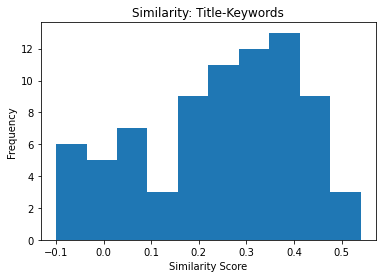

In [16]:
# show title-similarity distribution
plt.hist(df_titles['keyword_similarity'])
plt.title('Similarity: Title-Keywords')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [17]:
# filter out similarity score < 0.1
df_titles = df_titles[df_titles['keyword_similarity'] > 0.1]
df_titles = df_titles.sort_values(by='keyword_similarity', ascending=False, ignore_index=True)
df_titles

,source,title,date,keyword_similarity
0,chatgpt,Armut unter Rentnern,2023-03-07,0.54
1,https://www.mutter-teresa-stiftung.de/startsei...,Altersarmut,2022-11-03,0.53
2,chatgpt,Finanzielle Hilfen für Senioren in Not,2023-03-07,0.51
3,https://frauen.verdi.de/themen/rente/++co++c0b...,Frauen haben niedrigere Renten – ver,no date detected,0.46
4,chatgpt,Altersarmut bei Frauen,2023-03-07,0.45
5,https://www.destatis.de/DE/Themen/Querschnitt/...,Armutsgefährdung sowie materielle und soziale ...,2022-08-23,0.44
6,https://www.sparkasse.de/themen/finanzielle-un...,Rentenlücke bei Frauen in Deutschland,2023-03-02,0.43
7,https://www.deutsche-rentenversicherung.de/DRV...,Grundsicherung,2022-04-30,0.43
8,https://frauen.verdi.de/themen/rente/frauen-ge...,Frauen gegen Altersarmut – ver,2017-06-29,0.43
9,https://www.fr-altenhilfe.de/wem-sie-helfen/,Gemeinsam gegen Altersarmut,2021-05-20,0.42


## Save Topic Ideation as Word Document

In [18]:
# create a word document 
document = Document()

# add table to document
table = document.add_table(rows=1, cols=4)
table.style = 'Table Grid'

# add table header
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Source'
hdr_cells[1].text = 'Title'
hdr_cells[2].text = 'Date'
hdr_cells[3].text = 'Keyword Similarity'

# add data to table
for i in range(len(df_titles)):
    row_cells = table.add_row().cells
    row_cells[0].text = df_titles.iloc[i]['source']
    row_cells[1].text = df_titles.iloc[i]['title']
    row_cells[2].text = df_titles.iloc[i]['date']
    row_cells[3].text = str(df_titles.iloc[i]['keyword_similarity'])

# save word document
document.save('topic_ideation.docx')

# Advise ChatGPT to Write Article for Given Topic

In [19]:
topic = df_titles['title'][2]
print(topic)

Finanzielle Hilfen für Senioren in Not


In [20]:
instruction = "\n" + \
"Schreibe einen Artikel von 250 Wörtern zum Thema: \n" + \
topic + '. \n' + \
"Der Artikel soll die Schlüsselbegriffe " + '\n' + \
str(keywords) + '\n' + \
"enthalten." + '\n' + \
"Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein." + '\n' + \
"Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten."

print('Instruction: ', instruction)

Instruction:  
Schreibe einen Artikel von 250 Wörtern zum Thema: 
Finanzielle Hilfen für Senioren in Not. 
Der Artikel soll die Schlüsselbegriffe 
['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
enthalten.
Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein.
Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten.


In [21]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

text_seo = response['choices'][0].text

APIError: Internal server error {
    "error": {
        "message": "Internal server error",
        "type": "auth_subrequest_error",
        "param": null,
        "code": "internal_error"
    }
}
 500 {'error': {'message': 'Internal server error', 'type': 'auth_subrequest_error', 'param': None, 'code': 'internal_error'}} {'Date': 'Tue, 07 Mar 2023 11:49:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '166', 'Connection': 'keep-alive', 'Vary': 'Origin', 'X-Request-Id': 'da4d3c4fddb9df7e7e173bdc325bd690', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}

In [ ]:
print(text_seo)



Finanzielle Hilfe im Alter: Warum Frauen weniger Rente bekommen 

Frauen haben es schwer, im Alter finanziell abgesichert zu sein. Laut Statistiken erhalten sie deutlich niedrigere Renten als Männer und sind somit häufiger von Altersarmut betroffen. Dieser Renten-Pay-Gap ist eine große Herausforderung für die Politik, aber auch für jeden Einzelnen, der seine Rente im Alter verbessern möchte. 

Rentner in Not: Der Gender Pay Gap bei Renten 
Der Gender Pay Gap ist ein weit verbreitetes Problem in vielen Ländern. Auch bei den Renten zeigt sich dieser Unterschied: Im Schnitt erhalten Frauen rund 20 Prozent weniger Rente als Männer. Diese Diskrepanz hat vor allem mit den ungleichen Verdienstmöglichkeiten und der geringeren Erwerbsbeteiligung von Frauen zu tun. 

Armut Senioren: Gründe für die geringeren Rentenzahlungen an Frauen 
Einer der Gründe, warum Frauen wesentlich niedrigere Rentenzahlung erhalten, ist ihre geringere Erwerbsbeteiligung im Vergleich zu Männern. Da viele Frauen einen

## Save SEO Text as Word Document

In [ ]:
# Create a new document object.
document = Document()

# Create a new paragraph object.
paragraph = document.add_paragraph()

# Write the string to the paragraph object.
paragraph.add_run(text_seo)

# Save the document.
document.save('seo_text.docx')

# ToDo

- Include Keywords into article generation -> ok
- Add column with publication date! -> ok
- Save Topic List and hand over to Alexa -> warte auf Feedback
- correct topic titles
- code review: make functions
- develop streamlit app
    - update button for topic list after setting configs
    - download button for topic list